1. Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model for the dataset
https://datahub.io/core/natural-gas#resource-daily or

https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict the price for the 11th day.

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/daily.csv')
df.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [ ]:
df.isna().value_counts()

Date   Price
False  False    5952
       True        1
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isna().value_counts()

Date   Price
False  False    5952
dtype: int64

In [ ]:
y = df['Price'].values
x = np.arange(1,len(y),1)
print(x)
print(y)
len(y)

[   1    2    3 ... 5949 5950 5951]
[3.82 3.8  3.61 ... 2.46 2.3  2.22]


5952

In [ ]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1,1))
y = y.flatten()
y.shape

(5952,)

In [ ]:
Sequence_Length = 10
X = []
Y = []

for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])

In [ ]:
print(X)
print(Y)

[[0.1589213998852553, 0.15777395295467583, 0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304], [0.15777395295467583, 0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772], [0.14687320711417096, 0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607], [0.1646586345381526, 0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607, 0.1095811818703385], [0.16924842226047046, 0.16982214572576018, 0.18875502008032127, 0.2099827882960413, 0.16408491107286288, 0.1267928858290304, 0.11130235226620772, 0.11474469305794607

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10,random_state=42,shuffle=False,stratify=None)

In [ ]:
class NGTTimeSeries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

    def __len__(self):
        return len(self.x)

In [ ]:
dataset = NGTTimeSeries(X_train,Y_train)
train_loader = DataLoader(dataset,batch_size=256,shuffle=True)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output,status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.manual_seed(42)
model = RNNModel().to(device)
model

RNNModel(
  (rnn): RNN(1, 5, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 1500

In [ ]:
# Training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        y_pred = model(inputs.view(-1, Sequence_Length, 1)).reshape(-1)

        loss = criterion(y_pred, targets)

        loss.backward()

        optimizer.step()

    if i % 50 == 0:
        print(f"Epoch {i}: Loss:{loss}")


Epoch 0: Loss:0.03855091705918312
Epoch 50: Loss:0.007683319039642811
Epoch 100: Loss:0.002859849017113447
Epoch 150: Loss:0.0002800380461849272
Epoch 200: Loss:0.0005552626680582762
Epoch 250: Loss:0.0002701111661735922
Epoch 300: Loss:0.0002496507950127125
Epoch 350: Loss:0.00018147013906855136
Epoch 400: Loss:0.00011768762487918139
Epoch 450: Loss:0.00011905920837307349
Epoch 500: Loss:0.00019543430244084448
Epoch 550: Loss:0.00017361855134367943
Epoch 600: Loss:0.00010710742208175361
Epoch 650: Loss:0.00016138050705194473
Epoch 700: Loss:0.0001887437392724678
Epoch 750: Loss:0.0005147945485077798
Epoch 800: Loss:0.00022648645972367376
Epoch 850: Loss:0.0002738074690569192
Epoch 900: Loss:0.0002663569466676563
Epoch 950: Loss:0.0001291371154366061
Epoch 1000: Loss:0.00020119159307796508
Epoch 1050: Loss:0.00012012426304863766
Epoch 1100: Loss:0.0002542640140745789
Epoch 1150: Loss:0.00011955535592278466
Epoch 1200: Loss:0.00015366662410087883
Epoch 1250: Loss:0.00015023698506411165


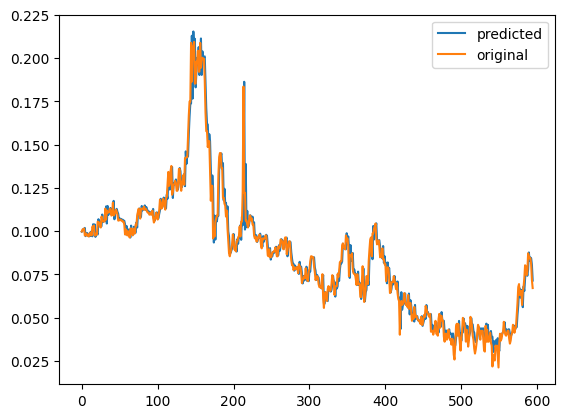

In [ ]:
test_set = NGTTimeSeries(X_test,Y_test)
test_inputs = test_set[:][0].to(device)

with torch.no_grad():
    test_pred = model(test_inputs.view(-1, 10, 1)).view(-1).cpu()

plt.plot(test_pred.numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1), label='original')
plt.legend()
plt.show()


2. The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of names stored in the format {language: [names ...]} i.e. each language contains a list of names. Train a RNN on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

In [ ]:
#!wget  https://download.pytorch.org/tutorial/data.zip

--2024-03-06 09:55:20--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.77, 18.160.200.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2024-03-06 09:55:20 (42.3 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
#!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
import string
import unicodedata
import glob
import os

In [ ]:
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
all_letters,n_letters

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'", 56)

In [ ]:
tensor = torch.zeros(1,n_letters)
tensor.shape

torch.Size([1, 56])

In [ ]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_data(data_dir):
    data = {}
    for filename in glob.glob(os.path.join(data_dir, '*.txt')):
        language = os.path.splitext(os.path.basename(filename))[0]
        names = open(filename, encoding='utf-8').read().strip().split('\n')
        data[language] = [unicode_to_ascii(name) for name in names]
    return data

In [ ]:
data = read_data('/content/data')
languages = list(data.keys())

In [ ]:
data

{'eng-fra': ['Go.Va',
  'RunCours',
  'RunCourez',
  'WowCaalors',
  'FireAufeu',
  "HelpAl'aide",
  'Jump.Saute.',
  'StopCasuffit',
  'StopStop',
  'StopArretetoi',
  'WaitAttends',
  'WaitAttendez',
  'Isee.Jecomprends.',
  "Itry.J'essaye.",
  "IwonJ'aigagne",
  "IwonJel'aiemporte",
  'OhnoOhnon',
  'AttackAttaque',
  'AttackAttaquez',
  'CheersSante',
  'CheersAvotresante',
  'CheersMerci',
  'Getup.Levetoi.',
  "GotitJ'aipige",
  'GotitCompris',
  'GotitPige',
  'GotitCompris',
  "GotitT'ascapte",
  'Hopin.Monte.',
  'Hopin.Montez.',
  'Hugme.Serremoidanstesbras',
  'Hugme.Serrezmoidansvosbras',
  'Ifell.Jesuistombee.',
  'Ifell.Jesuistombe.',
  'Iknow.Jesais.',
  'Ileft.Jesuisparti.',
  'Ileft.Jesuispartie.',
  "Ilost.J'aiperdu.",
  "I'm.J'aians.",
  "I'mOK.Jevaisbien.",
  "I'mOK.Cava.",
  'Listen.Ecoutez',
  'NowayImpossible',
  'NowayEnaucuncas.',
  "NowayC'esthorsdequestion",
  "NowayIln'enestpasquestion",
  "NowayC'estexclu",
  'NowayEnaucunemaniere',
  'NowayHorsdequestion',

In [ ]:
languages

['eng-fra']

In [ ]:
#one-hot-encoding
def letter_to_index(letter):
    return all_letters.find(letter)

print(letter_to_index('a'))

def letter_to_tensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('b'))

def name_to_tensor(name):
    tensor = torch.zeros(len(name),n_letters)
    for i,letter in enumerate(name):
        tensor[i][letter_to_index(letter)] = 1
    return tensor

print(name_to_tensor('benny'))



0
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size) #i2h is the dense input/output
        self.h2o = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output,hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 128
n_languages = len(languages)
torch.manual_seed(42)
rnn = RNN(n_letters,n_hidden,n_languages)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(),lr=0.005)
rnn

RNN(
  (i2h): Linear(in_features=184, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=1, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
def train(name_tensor,language_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    for i in range(name_tensor.size(0)):
        output,hidden = rnn(name_tensor[i],hidden)
    loss = criterion(output,language_tensor)
    loss.backward()
    optimizer.step()